In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Import All Dependencies

# Standard Library Imports
from collections import defaultdict
from pathlib import Path
import copy
import re
import warnings

# Third-Party Data & Math
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
)

# Image Processing
import cv2

# Visualization
import matplotlib.pyplot as plt

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.stateless import functional_call
from torch.utils.data import Dataset
from torchvision import transforms

# Utilities
from tqdm import tqdm

# Warning Control
warnings.filterwarnings("ignore")


#DATA PREPROCESSING

In [ ]:
## Set Dataset Paths

# Define dataset directories
BASE_DIR  = Path("/content/drive/MyDrive/Anemia_dataset")
INDIA_DIR = BASE_DIR / "India"
ITALY_DIR = BASE_DIR / "Italy"

# Quick existence check
print("Base dir exists:", BASE_DIR.exists())
print("India dir exists:", INDIA_DIR.exists())
print("Italy dir exists:", ITALY_DIR.exists())

Base dir exists: True
India dir exists: True
Italy dir exists: True


### Set Dataset Paths  
Define the base directory and sub-folders for the India and Italy datasets stored in Google Drive.

## INDIA

In [ ]:
## Load India Metadata Excel

# Path to India metadata file
INDIA_XLSX = INDIA_DIR / "India.xlsx"
print("India Excel exists:", INDIA_XLSX.exists())

# Load and preview metadata
df_india = pd.read_excel(INDIA_XLSX)
df_india.head()

India Excel exists: True


,Number,Hgb,Gender,Age,Note
0,1,12.2,M,29,NaN
1,2,8.0,F,36,NaN
2,3,10.7,F,30,NaN
3,4,8.3,F,39,NaN
4,5,7.8,F,29,NaN


### Load India Metadata Excel  
Load the India dataset’s metadata file `India.xlsx`, which contains patient information such as ID, hemoglobin level, gender, and age.

In [ ]:
## Define Rule-Based Anemia Label Function

def derive_anemia_label(hb):
    """
    Returns 'anemic' if Hb < 12.0, otherwise 'non-anemic'.
    """
    return "anemic" if hb < 12.0 else "non-anemic"

### Define Rule-Based Anemia Label  
A simple threshold-based function that converts hemoglobin (Hb) values into binary labels.  
If Hb is below 12.0, the patient is marked *anemic*; otherwise *non-anemic*.  
This serves as the ground-truth label for classification.


In [ ]:
## Add Anemia Label Column to India Metadata

df_india["Label"] = df_india.apply(
    lambda row: derive_anemia_label(row["Hgb"]),
    axis=1
)

df_india.head()

,Number,Hgb,Gender,Age,Note,Label
0,1,12.2,M,29,NaN,non-anemic
1,2,8.0,F,36,NaN,anemic
2,3,10.7,F,30,NaN,anemic
3,4,8.3,F,39,NaN,anemic
4,5,7.8,F,29,NaN,anemic


### Generate Anemia Labels for India Dataset  
This cell applies the rule-based anemia function to each row in the India metadata.


In [ ]:
## Select Best Conjunctiva Image for a Patient

def get_conjunctiva_image(patient_folder: Path):
    """
    Returns the preferred conjunctiva image for a patient.
    Priority:
      1. forniceal_palpebral crop
      2. palpebral crop
      3. forniceal crop
    """
    files = [f.name for f in patient_folder.iterdir() if f.is_file()]

    # Priority 1 : combined conjunctiva crop
    for f in files:
        if "forniceal_palpebral" in f.lower():
            return patient_folder / f

    # Priority 2 : palpebral only
    for f in files:
        if f.lower().endswith("palpebral.png") and "forniceal_palpebral" not in f.lower():
            return patient_folder / f

    # Priority 3 : forniceal only
    for f in files:
        if f.lower().endswith("forniceal.png") and "forniceal_palpebral" not in f.lower():
            return patient_folder / f

    return None

### Select Best Conjunctiva Image per Patient  
This helper function scans a patient’s folder and returns the most informative conjunctiva image.  
The selection follows a priority order:  
1. **forniceal_palpebral** (combined crop)  
2. **palpebral** (single crop)  
3. **forniceal** (single crop)  

If none are found, it returns `None`.  
This ensures consistent image selection for both preprocessing and model training.

In [ ]:
## Compute R/G Color Ratio for an Image

def compute_rg_ratio(image_path):
    """
    Computes mean(R) / mean(G) from an RGB image.
    Used as a simple color-based biomarker.
    """
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    R = img_rgb[:, :, 0].astype(np.float32)
    G = img_rgb[:, :, 1].astype(np.float32)

    eps = 1e-6  # avoid division by zero
    return float(R.mean() / (G.mean() + eps))

### Compute Red Green Ratio  
This function loads an image, converts it from BGR to RGB, and calculates the ratio of average Red intensity to average Green intensity.  


In [ ]:
## Build R/G Ratio DataFrame for All Patients

def build_rg_df(
    df_meta,
    base_dir,
    id_col="Number",
    hb_col="Hgb",
    label_col="Label",
):
    """
    Iterates over patient metadata and builds a dataframe containing:
      - patient_id
      - hemoglobin value
      - anemia label
      - selected conjunctiva image path
      - computed R/G ratio feature
    """
    records = []

    for _, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
        patient_id = int(row[id_col])
        hb        = float(row[hb_col])
        label     = row[label_col]

        patient_folder = base_dir / str(patient_id)
        if not patient_folder.exists():
            print(f"[WARN] Folder not found for patient {patient_id}")
            continue

        conj_img = get_conjunctiva_image(patient_folder)
        if conj_img is None:
            print(f"[WARN] No conjunctiva image found for patient {patient_id}")
            continue

        rg = compute_rg_ratio(conj_img)

        records.append({
            "patient_id": patient_id,
            "hb": hb,
            "label": label,
            "image_path": str(conj_img),
            "rg_ratio": rg,
        })

    return pd.DataFrame(records)

### Build R/G Ratio Dataset  
This function loops over all patient entries in the metadata and constructs a clean dataframe containing each patient’s hemoglobin value, anemia label, selected conjunctiva image, and computed R/G ratio.



In [ ]:
## Generate R/G Ratio Dataset for India

df_rg_india = build_rg_df(df_india, INDIA_DIR)
df_rg_india.head()

100%|██████████| 95/95 [00:35<00:00,  2.69it/s]


,patient_id,hb,label,image_path,rg_ratio
0,1,12.2,non-anemic,/content/drive/MyDrive/Anemia_dataset/India/1/...,1.474286
1,2,8.0,anemic,/content/drive/MyDrive/Anemia_dataset/India/2/...,1.801921
2,3,10.7,anemic,/content/drive/MyDrive/Anemia_dataset/India/3/...,1.225191
3,4,8.3,anemic,/content/drive/MyDrive/Anemia_dataset/India/4/...,1.177758
4,5,7.8,anemic,/content/drive/MyDrive/Anemia_dataset/India/5/...,1.257654


### Build India R/G Ratio DataFrame  
I ran the preprocessing pipeline for all India patients, generating a new dataframe that includes hemoglobin values, anemia labels, conjunctiva image paths, and their R/G ratios.

In [ ]:
## Prepare Feature (X) and Target (y)

X = df_rg_india["rg_ratio"].values.reshape(-1, 1)
y = df_rg_india["hb"].values

### Prepare Feature and Target  
Extract the R/G ratio as the input feature `X` and hemoglobin (Hb) as the target `y`.  
Reshaping is required because scikit-learn expects a 2D array for features.

In [ ]:
## Linear Regression on R/G Ratio vs Hb

reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)

print("R²:", r2)

R²: 0.16798324640848528


### Linear Regression on R/G Ratio vs Hb  
I fitted a simple linear regression model to check how much the R/G ratio explains variation in hemoglobin levels.  
The computed R² value is **0.1679**, meaning the model explains about 17% of the variance.


In [ ]:
## Pearson Correlation (linear relationship)

pearson_r, pearson_p = pearsonr(df_rg_india["rg_ratio"], df_rg_india["hb"])
print("Pearson r:", pearson_r, " p:", pearson_p)

Pearson r: 0.40985759283986084  p: 3.7131472026233497e-05


### Pearson Correlation (Linear Relationship)  
Here I compute the Pearson correlation between the R/G ratio and hemoglobin.  
The result is **r = 0.4099** with **p = 3.71e-05**, indicating a statistically significant moderate linear correlation.

In [ ]:
## Spearman Correlation (rank-based relationship)

spearman_r, spearman_p = spearmanr(df_rg_india["rg_ratio"], df_rg_india["hb"])
print("Spearman r:", spearman_r, " p:", spearman_p)

Spearman r: 0.5539018548636163  p: 5.79457263508906e-09


### Spearman Correlation (Rank-Based Relationship)  
I calculated Spearman’s rank correlation to capture monotonic trends.  
The result is **ρ = 0.5539** with **p = 5.79e-09**, showing a stronger monotonic relationship than the Pearson result.


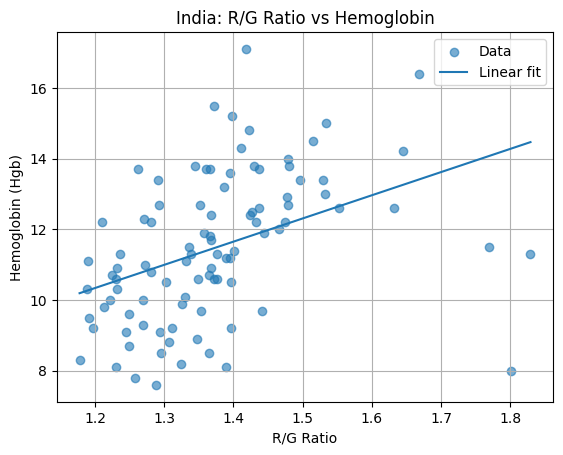

In [ ]:
## Scatter Plot with Linear Regression Line

# Visualize R/G ratio vs hemoglobin with fitted regression line
plt.figure()
plt.scatter(df_rg_india["rg_ratio"], df_rg_india["hb"], alpha=0.6, label="Data")

# Sort values so the regression line plots cleanly
sort_idx = np.argsort(df_rg_india["rg_ratio"].values)
plt.plot(
    df_rg_india["rg_ratio"].values[sort_idx],
    y_pred[sort_idx],
    label="Linear fit"
)

plt.xlabel("R/G Ratio")
plt.ylabel("Hemoglobin (Hgb)")
plt.title("India: R/G Ratio vs Hemoglobin")
plt.legend()
plt.grid(True)
plt.show()

### Scatter Plot of R/G Ratio vs Hemoglobin  
Here I generated a scatter plot of R/G ratio against hemoglobin for all India patients.  
A linear regression line is plotted on top after sorting the feature values, showing a **moderate upward trend**, consistent with the statistical correlations obtained earlier.

## ITALY

In [ ]:
## Load Italy Metadata Excel

# Path to Italy metadata file
ITALY_XLSX = ITALY_DIR / "Italy.xlsx"
print("Italy Excel exists:", ITALY_XLSX.exists())

# Load and preview metadata
df_italy = pd.read_excel(ITALY_XLSX)
df_italy.head()

Italy Excel exists: True


,Number,Hgb,Gender,Age,Note,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1,9.3,F,82,Forniceal conjunctiva not visible,NaN,NaN,NaN,NaN
1,2,10.2,F,77,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele
2,3,10.7,F,52,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele
3,4,11.7,F,73,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele
4,5,11.6,F,74,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele


### Load Italy Metadata Excel  
Loaded the Italy dataset metadata from `Italy.xlsx`, which includes patient information and hemoglobin values.


In [ ]:
## Check Column Data Types for Italy Metadata

# Print dtypes to inspect formatting issues (Hgb appears as object)
print(df_italy.dtypes)

Number          int64
Hgb            object
Gender         object
Age             int64
Note           object
Unnamed: 5    float64
Unnamed: 6     object
Unnamed: 7     object
Unnamed: 8     object
dtype: object


### Check Italy Metadata Column Types  
Printed the data types for each column in the Italy metadata.  
The output shows that **Hgb is stored as an object**, meaning the hemoglobin values were likely loaded as strings.  
I will need to clean and convert this column to numeric before further processing.


In [ ]:
## Clean Italy Hgb Column (Convert to Numeric)

# Convert Hgb values to proper numeric format
df_italy["Hgb"] = (
    df_italy["Hgb"]
    .astype(str)
    .str.replace(",", ".", regex=False)  # handle comma decimals
    .str.strip()
    .pipe(pd.to_numeric, errors="coerce")  # convert to float, invalid → NaN
)

# Remove rows where Hgb could not be converted
df_italy = df_italy.dropna(subset=["Hgb"])

### Clean Italy Hgb Column  
Since Hgb was loaded as text, this cell converts the values into proper numeric format by replacing comma decimals, stripping spaces, and coercing invalid entries to NaN.  
Rows with missing or invalid Hgb values are then dropped to ensure the dataset is clean for further processing.

In [ ]:
## Add Anemia Label Column to Italy Metadata

df_italy["Label"] = df_italy.apply(
    lambda row: derive_anemia_label(row["Hgb"]),
    axis=1
)

df_italy.head()

,Number,Hgb,Gender,Age,Note,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Label
0,1,9.3,F,82,Forniceal conjunctiva not visible,NaN,NaN,NaN,NaN,anemic
1,2,10.2,F,77,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele,anemic
2,3,10.7,F,52,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele,anemic
3,4,11.7,F,73,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele,anemic
4,5,11.6,F,74,da segmentare la forniceale,NaN,NaN,NaN,Segmentato da Michele,anemic


### Generate Anemia Labels for Italy Dataset  
I applied the same Hb-based rule used for the India data to create an anemia label for each Italy patient.


In [ ]:
## Generate R/G Ratio Dataset for Italy

df_rg_italy = build_rg_df(df_italy, ITALY_DIR)
df_rg_italy.head()

100%|██████████| 122/122 [00:41<00:00,  2.94it/s]


,patient_id,hb,label,image_path,rg_ratio
0,1,9.3,anemic,/content/drive/MyDrive/Anemia_dataset/Italy/1/...,1.024357
1,2,10.2,anemic,/content/drive/MyDrive/Anemia_dataset/Italy/2/...,1.034392
2,3,10.7,anemic,/content/drive/MyDrive/Anemia_dataset/Italy/3/...,1.029288
3,4,11.7,anemic,/content/drive/MyDrive/Anemia_dataset/Italy/4/...,1.043463
4,5,11.6,anemic,/content/drive/MyDrive/Anemia_dataset/Italy/5/...,1.029680


### Build Italy R/G Ratio DataFrame  
Just like for India this cell runs the preprocessing pipeline for all Italy patients, generating a new dataframe that includes hemoglobin values, anemia labels, conjunctiva image paths, and their R/G ratios.

In [ ]:
## Prepare Feature (X) and Target (y) for Italy

X = df_rg_italy["rg_ratio"].values.reshape(-1, 1)
y = df_rg_italy["hb"].values

### Prepare Feature and Target (Italy)  
Extract the R/G ratio as feature `X` and hemoglobin (Hb) as target `y` for the Italy dataset.  

In [ ]:
## Linear Regression on Italy R/G Ratio vs Hb

reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)

print("R²:", r2)

R²: 0.29189807007054613


### Linear Regression on R/G Ratio vs Hb (Italy)  
The computed R² value is **0.2919**, indicating that about **29%** of the Hb variation is explained by the color ratio.


In [ ]:
## Pearson Correlation (Italy)

pearson_r, pearson_p = pearsonr(df_rg_italy["rg_ratio"], df_rg_italy["hb"])
print("Pearson r:", pearson_r, " p:", pearson_p)

Pearson r: 0.5402759203134505  p: 1.3375990216279454e-10


### Pearson Correlation (Italy)  
Pearson r is **0.5403** with **p = 1.33e-10**, showing a statistically significant moderate linear correlation.


In [ ]:
## Spearman Correlation (Italy)

spearman_r, spearman_p = spearmanr(df_rg_italy["rg_ratio"], df_rg_italy["hb"])
print("Spearman r:", spearman_r, " p:", spearman_p)

Spearman r: 0.5382492501894796  p: 1.6150524633047988e-10


### Spearman Correlation (Italy)  
Spearman ρ is **0.5382** with **p = 1.61e-10**, indicating a strong monotonic trend consistent with Pearson results.

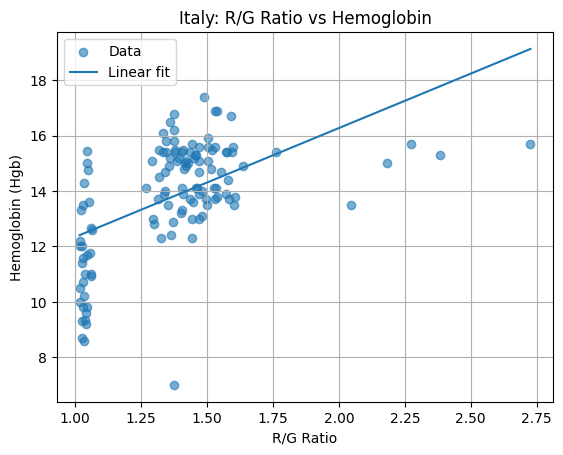

In [ ]:
## Scatter Plot with Linear Regression Line (Italy)

# Visualize R/G ratio vs hemoglobin for Italy with fitted regression line
plt.figure()
plt.scatter(df_rg_italy["rg_ratio"], df_rg_italy["hb"], alpha=0.6, label="Data")

# Sort values so the regression line is not jagged
sort_idx = np.argsort(df_rg_italy["rg_ratio"].values)
plt.plot(
    df_rg_italy["rg_ratio"].values[sort_idx],
    y_pred[sort_idx],
    label="Linear fit"
)

plt.xlabel("R/G Ratio")
plt.ylabel("Hemoglobin (Hgb)")
plt.title("Italy: R/G Ratio vs Hemoglobin")
plt.legend()
plt.grid(True)
plt.show()

### Scatter Plot of R/G Ratio vs Hemoglobin (Italy)  
The points show a clear upward trend, consistent with the Italy results (R² ≈ 0.29, Pearson r ≈ 0.54, Spearman ρ ≈ 0.54), indicating a stronger relationship than in the India cohort.


#DATA AUGMENTATION

In [ ]:
## Set Augmented Dataset Paths

# Define augmented dataset directories
AUG_BASE      = BASE_DIR / "Augmented_Data"
AUG_INDIA_DIR = AUG_BASE / "India"
AUG_ITALY_DIR = AUG_BASE / "Italy"

# Existence checks
print("Aug base exists:", AUG_BASE.exists())
print("Aug India exists:", AUG_INDIA_DIR.exists())
print("Aug Italy exists:", AUG_ITALY_DIR.exists())

Aug base exists: True
Aug India exists: True
Aug Italy exists: True


### Set Augmented Dataset Paths  
This cell defines the directory paths for the augmented version of both India and Italy datasets.


In [ ]:
## Retrieve Augmented Images for a Given Patient

def get_augmented_images(patient_id: int, base_dir):
    """
    Returns a sorted list of augmented .png images for a patient.
    Looks for files starting with 'aug_' inside patient folder.
    """
    folder = base_dir / str(patient_id)
    if not folder.exists():
        return []

    return sorted(
        [
            p for p in folder.iterdir()
            if p.is_file() and p.name.startswith("aug_") and p.suffix.lower() == ".png"
        ]
    )

### Get Augmented Images per Patient  
This function returns all augmented `.png` images for a given patient by scanning their folder for files beginning with `aug_`.  
If the patient's folder does not exist, it returns an empty list.

In [ ]:
## Build Augmentation Statistics per Patient

def build_aug_stats(df_meta: pd.DataFrame, base_dir, id_col="Number", label_col="Label") -> pd.DataFrame:
    """
    For each patient in metadata:
      - count how many augmented images exist
      - store patient_id, label, and augmentation count
    """
    rows = []

    for _, row in df_meta.iterrows():
        pid   = int(row[id_col])
        label = row[label_col]

        aug_paths = get_augmented_images(pid, base_dir)

        rows.append({
            "patient_id": pid,
            "label": label,
            "num_aug_images": len(aug_paths),
        })

    return pd.DataFrame(rows)

### Build Augmentation Statistics  
This function loops through all patients in the metadata and counts how many augmented images exist for each one.  
It returns a dataframe containing the patient ID, anemia label, and the number of augmented samples available.

## INDIA

In [ ]:
## Build Augmentation Stats for India

df_india_aug = build_aug_stats(df_india, AUG_INDIA_DIR)
df_india_aug.head()

,patient_id,label,num_aug_images
0,1,non-anemic,13
1,2,anemic,13
2,3,anemic,13
3,4,anemic,13
4,5,anemic,13


### Augmentation Stats for India  
I generated a dataframe showing how many augmented images exist for each India patient.


In [ ]:
## Compute Image-Level Class Balance for India (Augmented)

image_level_balance_india = (
    df_india_aug
    .groupby("label")["num_aug_images"]
    .sum()
    .rename("num_images")
)

print("Image-level class balance (India, augmented only):")
print(image_level_balance_india)

Image-level class balance (India, augmented only):
label
anemic        728
non-anemic    507
Name: num_images, dtype: int64


### Image-Level Class Balance (India, Augmented)  
This cell sums the total number of augmented images available for each class (anemic vs non-anemic).  
The result shows:
- **anemic: 728 images**  
- **non-anemic: 507 images**  

The augmented dataset is somewhat imbalanced, with more anemic images than non-anemic ones.


## ITALY


In [ ]:
## Build Augmentation Stats for Italy

df_italy_aug = build_aug_stats(df_italy, AUG_ITALY_DIR)
df_italy_aug.head()

,patient_id,label,num_aug_images
0,1,anemic,13
1,2,anemic,13
2,3,anemic,13
3,4,anemic,13
4,5,anemic,13


### Augmentation Stats for Italy
Just like for India I generated a dataframe showing how many augmented images exist for each Italy patient.


In [ ]:
## Compute Image-Level Class Balance for Italy (Augmented)

image_level_balance_italy = (
    df_italy_aug
    .groupby("label")["num_aug_images"]
    .sum()
    .rename("num_images")
)

print("Image-level class balance (Italy, augmented only):")
print(image_level_balance_italy)

Image-level class balance (Italy, augmented only):
label
anemic         260
non-anemic    1235
Name: num_images, dtype: int64


### Image-Level Class Balance (Italy, Augmented)    
The output shows:
- **anemic: 260 images**  
- **non-anemic: 1235 images**  

This augmented set is **highly imbalanced**, with far more non-anemic samples.


# Dataset Splits

In [ ]:
## Get Unique Patient IDs for India

india_patients = df_india["Number"].astype(int).unique()
india_patients = np.sort(india_patients)

print("Total India patients:", len(india_patients))

Total India patients: 95


### Unique India Patient IDs  
I extractd and sorts all unique patient IDs from the India metadata.  
The output confirms there are **95 distinct India patients** in the dataset.

In [ ]:
## Reproducibly Shuffle India Patient IDs

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

shuffled = india_patients.copy()
rng.shuffle(shuffled)

### Reproducible Shuffling of Patients  
Here I created a reproducible random shuffle of the 95 India patient IDs using a fixed seed (`42`).  
This shuffled list will be used to create consistent train/validation splits.

In [ ]:
## Create 70/30 Train–Validation Split (Patient-Level, India)

split_idx = int(0.7 * len(shuffled))
train_patients = shuffled[:split_idx]
val_patients   = shuffled[split_idx:]

### 70/30 Patient-Level Split (India)  
I splited the shuffled patient IDs into:
- 70% for **training**,  
- 30% for **validation**,  

ensuring that each patient appears in only one split as asked.

In [ ]:
## Show Number of Train and Validation Patients (India)

print("Train patients:", len(train_patients))
print("Val patients: ", len(val_patients))

Train patients: 66
Val patients:  29


### Train vs Validation Counts (India)  
Printed how many patients fall into each split.  
For India:
- **Train patients: 66**  
- **Validation patients: 29**  

These counts sum back to the 95 unique patients.

In [ ]:
## Build Patient-Level Table for India (with Hb for regression)

df_india_patients = (
    df_india[["Number", "Label", "Hgb"]]
    .drop_duplicates()
    .rename(columns={"Number": "patient_id", "Hgb": "hb"})
)


### Create Patient-Level India Table  
Collapsed the India metadata to **one row per patient**, keeping only the patient ID and anemia label.  
Duplicate rows are removed and the `Number` column is renamed to `patient_id` for clarity.

In [ ]:
## Attach Train/Val Split to India Patients

df_india_patients["split"] = np.where(
    df_india_patients["patient_id"].isin(train_patients),
    "train",
    "val",
)

df_india_patients.head()

,patient_id,Label,split
0,1,non-anemic,train
1,2,anemic,train
2,3,anemic,train
3,4,anemic,train
4,5,anemic,train


### Assign Split Labels to India Patients  
Here I added a new `split` column to the patient-level table, marking each patient as either **train** or **val** based on the previously defined splits.  

In [ ]:
## Patient-Level Class Balance for India

patient_counts_india = (
    df_india_patients
    .groupby(["split", "Label"])["patient_id"]
    .nunique()
    .unstack(fill_value=0)
)

print("Patient-level class counts (India):")
print(patient_counts_india)

Patient-level class counts (India):
Label  anemic  non-anemic
split                    
train      35          31
val        21           8


### Patient-Level Class Balance (India)  
I computed how many **patients** (not images) belong to each class within each split.  
From the output, I got:

- **Train split:** anemic = 35, non-anemic = 31  
- **Val split:** anemic = 21, non-anemic = 8  

This shows a moderate imbalance in the validation set.

In [ ]:
## Image-Level Class Balance for India (Original + Augmented)

# Attach split info to augmented counts
df_india_imgs = df_india_aug.merge(
    df_india_patients[["patient_id", "split"]],
    on="patient_id",
    how="left",
)

# Total images = 1 original + augmented count
df_india_imgs["total_images"] = df_india_imgs["num_aug_images"] + 1

# Summarize at image level
image_counts_india = (
    df_india_imgs
    .groupby(["split", "label"])["total_images"]
    .sum()
    .unstack(fill_value=0)
)

print("Image-level class counts (India):")
print(image_counts_india)

Image-level class counts (India):
label  anemic  non-anemic
split                    
train     490         434
val       294         112


### Image-Level Class Balance (India)  
Added the train/val split to each patient’s augmented image count,  
computes **1 (original) + augmented**, and sums totals per split and label.

The actual counts are:

- **Train split:** anemic = 498 images, non-anemic = 434  
- **Val split:** anemic = 294 images, non-anemic = 112  

The validation split is more imbalanced, with anemic cases dominating.


In [ ]:
## Create Patient-Level Table for Italy (with Hb for regression)

df_italy_patients = (
    df_italy[["Number", "Label", "Hgb"]]
    .drop_duplicates()
    .rename(columns={"Number": "patient_id", "Hgb": "hb"})
)


### Create Patient-Level Italy Table  
Just like India reduced the Italy metadata to **one row per patient**, keeping only the patient ID and anemia label.


In [ ]:
## Mark All Italy Patients as Test Split

df_italy_patients["split"] = "test"
df_italy_patients.head()

,patient_id,Label,split
0,1,anemic,test
1,2,anemic,test
2,3,anemic,test
3,4,anemic,test
4,5,anemic,test


### Assign Test Split to Italy Patients  
All Italy patients are assigned to a single `test` split (no train/val division).


In [ ]:
## Patient-Level Class Balance for Italy

patient_counts_italy = (
    df_italy_patients
    .groupby(["split", "Label"])["patient_id"]
    .nunique()
    .unstack(fill_value=0)
)

print("Patient-level class counts (Italy):")
print(patient_counts_italy)

Patient-level class counts (Italy):
Label  anemic  non-anemic
split                    
test       20         102


### Patient-Level Class Balance (Italy)  
The output shows:
- **test split:** anemic = 20, non-anemic = 102  

This indicates that the Italy test set is skewed towards non-anemic patients.


In [ ]:
## Image-Level Class Balance for Italy (Original + Augmented)

# Attach test split info to augmented image counts
df_italy_imgs = df_italy_aug.merge(
    df_italy_patients[["patient_id", "split"]],
    on="patient_id",
    how="left",
)

# Total images = 1 original + augmented
df_italy_imgs["total_images"] = df_italy_imgs["num_aug_images"] + 1

# Summarize totals per split and label
image_counts_italy = (
    df_italy_imgs
    .groupby(["split", "label"])["total_images"]
    .sum()
    .unstack(fill_value=0)
)

print("Image-level class counts (Italy):")
print(image_counts_italy)

Image-level class counts (Italy):
label  anemic  non-anemic
split                    
test      280        1337


### Image-Level Class Balance (Italy)  

The results for the Italy **test** split are:

- **anemic:** 280 images  
- **non-anemic:** 1337 images  

This shows a strong imbalance toward non-anemic samples in the Italy dataset.


In [ ]:
## Combine Patient-Level Class Counts (India + Italy)

# India: patients per split and class
patient_counts_india = (
    df_india_patients
    .groupby(["split", "Label"])["patient_id"]
    .nunique()
    .unstack(fill_value=0)
)

# Italy: patients per split and class (all in 'test')
patient_counts_italy = (
    df_italy_patients
    .groupby(["split", "Label"])["patient_id"]
    .nunique()
    .unstack(fill_value=0)
)

# Combine both datasets into one table
patient_counts = pd.concat([patient_counts_india, patient_counts_italy])
patient_counts = patient_counts.rename_axis("Split").reset_index()

# Rename columns for clearer reporting
patient_counts = patient_counts.rename(columns={
    "anemic": "#Patients Anemic",
    "non-anemic": "#Patients Non-Anemic",
})

### Combined Patient-Level Class Counts (India + Italy)  
Merged the patient-level class distribution from both the India (train/val) and Italy (test-only) datasets.  
The resulting table reports, for each split, the number of anemic and non-anemic patients, giving a clear overview of patient distribution across the entire dataset structure.


In [ ]:
## Combine Image-Level Class Counts (India + Italy)

# India
# Merge augmented counts with patient metadata (label + split)
df_india_imgs = df_india_aug.merge(
    df_india_patients[["patient_id", "Label", "split"]],
    on="patient_id",
    how="left",
)

# Total = 1 original + augmented
df_india_imgs["total_images"] = df_india_imgs["num_aug_images"] + 1

# Summarize by split + label
image_counts_india = (
    df_india_imgs
    .groupby(["split", "Label"])["total_images"]
    .sum()
    .unstack(fill_value=0)
)

# Italy
df_italy_imgs = df_italy_aug.merge(
    df_italy_patients[["patient_id", "Label", "split"]],
    on="patient_id",
    how="left",
)

df_italy_imgs["total_images"] = df_italy_imgs["num_aug_images"] + 1

image_counts_italy = (
    df_italy_imgs
    .groupby(["split", "Label"])["total_images"]
    .sum()
    .unstack(fill_value=0)
)

# Combine
image_counts = pd.concat([image_counts_india, image_counts_italy])
image_counts = image_counts.rename_axis("Split").reset_index()

image_counts = image_counts.rename(columns={
    "anemic": "#Images Anemic",
    "non-anemic": "#Images Non-Anemic",
})

### Combined Image-Level Class Counts (India + Italy)  
Computed the total number of images per class and split for both countries.  
For each patient, the total number of images is calculated as **1 original + augmented images**.  
We then group by split (train, val, test) and class label to create a unified image-level summary across the full dataset.


In [ ]:
## Merge Patient-Level and Image-Level Counts into Final Summary

# Merge patient and image statistics by split
final_summary = patient_counts.merge(image_counts, on="Split")

# Order splits as train → val → test
split_order = ["train", "val", "test"]
final_summary["Split"] = pd.Categorical(final_summary["Split"], categories=split_order, ordered=True)
final_summary = final_summary.sort_values("Split").reset_index(drop=True)

print("FINAL DATASET SUMMARY (patients + images per class)")
display(final_summary)

FINAL DATASET SUMMARY (patients + images per class)


Label,Split,#Patients Anemic,#Patients Non-Anemic,#Images Anemic,#Images Non-Anemic
0,train,35,31,490,434
1,val,21,8,294,112
2,test,20,102,280,1337


### Final Dataset Summary (Patients + Images per Class)  
Marged the patient-level and image-level statistics into a single summary table for all splits:

- **Train:**  
  - Patients - anemic: 35, non-anemic: 31  
  - Images - anemic: 490, non-anemic: 434  

- **Val:**  
  - Patients - anemic: 21, non-anemic: 8  
  - Images - anemic: 294, non-anemic: 112  

- **Test (Italy):**  
  - Patients - anemic: 20, non-anemic: 102  
  - Images - anemic: 280, non-anemic: 1337  

This provides a clear overview of how balanced (or imbalanced) each split is at both the patient and image level before meta-learning and evaluation.


### Meta-Learning Setup (MAML)

In [ ]:
## Retrieve Original + Augmented Images for a Patient

def get_all_images_for_patient(patient_id: int, base_dir: Path):
    """
    Returns:
      - the original image (if present)
      - a sorted list of augmented images (aug_*.png)
    """
    folder = base_dir / str(patient_id)
    if not folder.exists():
        return None, []

    # Original image (if available)
    orig_path = folder / "original.png"
    if not orig_path.exists():
        orig_path = None

    # Augmented images
    aug_paths = sorted(
        [
            p for p in folder.iterdir()
            if p.is_file() and p.name.startswith("aug_") and p.suffix.lower() == ".png"
        ]
    )

    return orig_path, aug_paths

### Get Original + Augmented Images for a Patient  
This helper function returns both the **original image** (if it exists) and all **augmented images** for a given patient.  
It searches the patient’s folder for `original.png` and any files beginning with `aug_`.  
If the folder does not exist, it returns `(None, [])`.

In [ ]:
## Build Image-Level Table (Original Only or Original + Augmented)

def build_image_table_from_augmented(df_patients, aug_base_dir, country_name, use_augmented=True):
    """
    Builds a table containing one row per image (original + optionally augmented).
    Each row includes:
      - patient_id
      - split (train/val/test)
      - label string
      - hemoglobin value (hb)
      - image_path
      - source type ("original" or "augmented")
      - country name

    If use_augmented=False, only the original image is used.
    """
    rows = []

    for _, row in df_patients.iterrows():
        pid       = int(row["patient_id"])
        label_str = row["Label"]
        split     = row["split"]
        hb        = float(row["hb"])

        orig_path, aug_paths = get_all_images_for_patient(pid, aug_base_dir)

        # Add original image (if present)
        if orig_path is not None:
            rows.append({
                "patient_id": pid,
                "split": split,
                "label_str": label_str,
                "hb": hb,
                "image_path": str(orig_path),
                "source": "original",
                "country": country_name,
            })

        # Optionally add augmented images
        if use_augmented:
            for p in aug_paths:
                rows.append({
                    "patient_id": pid,
                    "split": split,
                    "label_str": label_str,
                    "hb": hb,
                    "image_path": str(p),
                    "source": "augmented",
                    "country": country_name,
                })

    return pd.DataFrame(rows)


### Build Image-Level Table (Original Only or Original + Augmented)

This function creates a complete image-level dataframe for a given country.  
For each patient, it retrieves the original image and—depending on the `use_augmented` flag—optionally includes all augmented images.

Each image is represented as a separate row containing:

- **patient_id**
- **split** (train / val / test)
- **label_str** (anemic / non-anemic)
- **image_path** (full path to the file)
- **source** (`"original"` or `"augmented"`)
- **country** (India or Italy)

If `use_augmented=False`, only the original image is added and all augmented images are excluded.  
The output is a standardized table suitable for dataset construction and episodic sampling.


In [ ]:
## Build Image-Level Table for India

df_images_india = build_image_table_from_augmented(
    df_india_patients,
    AUG_INDIA_DIR,
    country_name="India",
)

### Image Table for India  
Built the full image-level dataframe for the **India** (original + augmented images), using the patient metadata and augmented image folders.

In [ ]:
## Build Image-Level Table for Italy

df_images_italy = build_image_table_from_augmented(
    df_italy_patients,
    AUG_ITALY_DIR,
    country_name="Italy",
    use_augmented=False,  # <-- only original.png per patient
)


### Image Table for Italy  
Done almost the same thing for Italy as well just set `use_augmented = true` so only original cropped forniceal papebral is selected.


In [ ]:
## Concatenate India and Italy Image Tables

df_images = pd.concat([df_images_india, df_images_italy], ignore_index=True)

print("df_images shape:", df_images.shape)
display(df_images.head())


df_images shape: (1445, 6)


,patient_id,split,label_str,image_path,source,country
0,1,train,non-anemic,/content/drive/MyDrive/Anemia_dataset/Augmente...,original,India
1,1,train,non-anemic,/content/drive/MyDrive/Anemia_dataset/Augmente...,augmented,India
2,1,train,non-anemic,/content/drive/MyDrive/Anemia_dataset/Augmente...,augmented,India
3,1,train,non-anemic,/content/drive/MyDrive/Anemia_dataset/Augmente...,augmented,India
4,1,train,non-anemic,/content/drive/MyDrive/Anemia_dataset/Augmente...,augmented,India


### Combined Image Table (India + Italy)  
Here I concatenated the India and Italy image tables into a single dataframe `df_images`.  
The printed shape is **(1445, 6)**


In [ ]:
## Sanity Check: Images per Split and Label

print("Images per split & label_str:")
display(
    df_images
    .groupby(["split", "label_str"])["image_path"]
    .count()
    .unstack(fill_value=0)
)

Images per split & label_str:


label_str,anemic,non-anemic
split,,
test,20,95
train,490,434
val,294,112


### Images per Split and Label (Sanity Check)  
Checked how many images belong to each class within each split using the combined `df_images` table. the count of test set is significantly low because I have only selected orignal cropped forniceal papebral from Italy set.

The output shows:

- **train:** anemic = 490, non-anemic = 434  
- **val:**   anemic = 294, non-anemic = 112  
- **test:**  anemic = 20, non-anemic = 95  


In [ ]:
## Map String Labels to Numeric Labels (Required for PyTorch)

label_map = {"non-anemic": 0, "anemic": 1}

# Add numeric label column
df_images["label"] = df_images["label_str"].map(label_map).astype(int)

print("Label mapping check:")
display(
    df_images[["label_str", "label"]]
    .drop_duplicates()
    .sort_values("label")
)


Label mapping check:


,label_str,label
0,non-anemic,0
14,anemic,1


### Convert String Labels to Numeric Labels  
Mapped the textual class labels to numeric values required for PyTorch:
- **non-anemic → 0**  
- **anemic → 1**  


In [ ]:
## Image Transform and PyTorch Dataset Class (regression target = Hb)

# Basic transform: RGB → tensor + resize
img_transform = transforms.Compose([
    transforms.ToTensor(),          # HWC [0–255] -> CHW [0–1]
    transforms.Resize((128, 128)),  # resize for uniform input
])


class ConjunctivaImageDataset(Dataset):
    """
    PyTorch dataset for conjunctiva images (original + augmented).
    Expects a dataframe where each row represents a single image.
    Returns:
        - img_tensor: Float tensor [C, H, W]
        - hb: float hemoglobin value (regression target)
        - patient_id: integer patient identifier
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Read image in RGB
        img_bgr = cv2.imread(row["image_path"])
        if img_bgr is None:
            raise FileNotFoundError(f"Could not read image: {row['image_path']}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.uint8)

        # Apply transform
        if self.transform:
            img_tensor = self.transform(img_rgb)
        else:
            img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

        hb         = float(row["hb"])
        patient_id = int(row["patient_id"])

        return img_tensor, hb, patient_id


### PyTorch Dataset for Conjunctiva Images  
Defined the dataset used by the dataloaders.  
Each row in `df_images` becomes a single sample.  
The dataset loads the image from disk, converts it to RGB, applies the transform, and returns:

- the image tensor  
- the numeric label (0/1)  
- the patient ID (needed for patient-level accuracy later)

In [ ]:
## EpisodeSampler: setup patient/image indexing structure

class EpisodeSampler:
    """
    Sampler that builds patient-level few-shot episodes.
    """

    def __init__(self, df_split):
        # Keep a clean copy of the split dataframe
        self.df = df_split.reset_index(drop=True)

        # Build mappings
        self.patient_label_to_indices = defaultdict(list)
        self.label_to_patients        = defaultdict(set)

        for idx, row in self.df.iterrows():
            pid   = int(row["patient_id"])
            label = int(row["label"])
            self.patient_label_to_indices[(pid, label)].append(idx)
            self.label_to_patients[label].add(pid)

### EpisodeSampler: build patient–image indexing structure  
I defined the `EpisodeSampler` class and its constructor.  
For a given split (train / val / test), it builds:
- a mapping from `(patient_id, label)` → list of image indices, and  
- a mapping from `label` → set of patient IDs.  

These structures are reused by the episode sampling methods defined in the next cells.

In [ ]:
## EpisodeSampler: same-patient episode sampling

def _episode_sampler_sample_same_patient_episode(self, K=1, n_query_per_class=5, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    support_indices = []
    query_indices   = []

    for label in [0, 1]:
        patients = list(self.label_to_patients[label])
        if len(patients) == 0:
            raise ValueError(f"No patients with label {label} in this split.")

        # Find a patient with enough images
        while True:
            pid = rng.choice(patients)
            idx_list = self.patient_label_to_indices[(pid, label)]

            if len(idx_list) >= K + n_query_per_class:
                idx_list = idx_list.copy()
                rng.shuffle(idx_list)
                support_indices.extend(idx_list[:K])
                query_indices.extend(idx_list[K:K + n_query_per_class])
                break

            patients.remove(pid)
            if not patients:
                raise ValueError(
                    f"Not enough images for same-patient episode, "
                    f"label={label}, K={K}, n_query={n_query_per_class}"
                )

    return support_indices, query_indices


# Attach as a method of EpisodeSampler
EpisodeSampler.sample_same_patient_episode = _episode_sampler_sample_same_patient_episode

### EpisodeSampler: same-patient episode sampling  
Defined and attaches the method that creates **same-patient episodes**.  

For each class (0 = non-anemic, 1 = anemic), it:
- selects a single patient with that label, and  
- samples `K` support + `n_query_per_class` query images  
  **from the same patient**.  

The function is then bound to `EpisodeSampler.sample_same_patient_episode`.


In [ ]:
## EpisodeSampler: different-patient episode sampling

def _episode_sampler_sample_different_patient_episode(self, K=1, n_query_per_class=5, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    support_indices = []
    query_indices   = []

    for label in [0, 1]:
        patients = list(self.label_to_patients[label])
        if len(patients) < 2:
            raise ValueError(
                f"Need two patients with label={label} for different-patient episode."
            )

        rng.shuffle(patients)
        found = False

        for i in range(len(patients)):
            for j in range(i + 1, len(patients)):
                pid_s = patients[i]
                pid_q = patients[j]

                s_list = self.patient_label_to_indices[(pid_s, label)]
                q_list = self.patient_label_to_indices[(pid_q, label)]

                if len(s_list) >= K and len(q_list) >= n_query_per_class:
                    s_list = s_list.copy()
                    q_list = q_list.copy()
                    rng.shuffle(s_list)
                    rng.shuffle(q_list)

                    support_indices.extend(s_list[:K])
                    query_indices.extend(q_list[:n_query_per_class])
                    found = True
                    break
            if found:
                break

        if not found:
            raise ValueError("Could not build episode.")

    return support_indices, query_indices


# Attach as a method of EpisodeSampler
EpisodeSampler.sample_different_patient_episode = _episode_sampler_sample_different_patient_episode

### EpisodeSampler: different-patient episode sampling  
Defined and attaches the method that creates **different-patient episodes**.  

For each class, it:
- chooses **two different patients** with that label,  
- samples `K` support images from one patient and  
  `n_query_per_class` query images from the other.  

Each patient appears in **support or query, but not both**, which better matches a true generalization setting.

In [ ]:
## EpisodeSampler: mixed same/different episode

def _episode_sampler_sample_episode(self, K=1, n_query_per_class=5, p_same=0.3, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    if rng.random() < p_same:
        s_idx, q_idx = self.sample_same_patient_episode(K=K, n_query_per_class=n_query_per_class, rng=rng)
        e_type = "same_patient"
    else:
        s_idx, q_idx = self.sample_different_patient_episode(K=K, n_query_per_class=n_query_per_class, rng=rng)
        e_type = "different_patient"

    return s_idx, q_idx, e_type


# Attach as a method of EpisodeSampler
EpisodeSampler.sample_episode = _episode_sampler_sample_episode

### EpisodeSampler: mixed same/different episode  
Defined the high-level `sample_episode` method.  

For each episode it:
- flips a coin with probability `p_same`,  
- calls either `sample_same_patient_episode` or `sample_different_patient_episode`, and  
- returns the support indices, query indices, and the episode type string.  

This lets us mix both episode types during meta-training.


In [ ]:
## ItalyEpisodeSampler: setup label-level indexing

class ItalyEpisodeSampler:
    """
    Episode sampler for Italy TEST:
    - Uses only original images (df_test should already be original-only).
    - Builds episodes by sampling across multiple patients per class.
    """

    def __init__(self, df_split):
        # Keep a clean copy of the split dataframe
        self.df = df_split.reset_index(drop=True)

        # Build label -> list of indices mapping
        self.label_to_indices = defaultdict(list)
        for idx, row in self.df.iterrows():
            label = int(row["label"])
            self.label_to_indices[label].append(idx)


In [ ]:
## ItalyEpisodeSampler: class-balanced episode sampling

def _italy_episode_sampler_sample_episode(
    self,
    K=1,
    n_query_per_class=5,
    p_same=None,   # kept for API compatibility; not used here
    rng=None,
):
    """
    Build one class-balanced episode:
      - For each label in {0,1}:
          * pick K support indices
          * pick n_query_per_class query indices (disjoint from support)

    Assumes there are at least K + n_query_per_class images per label.
    """
    if rng is None:
        rng = np.random.default_rng()

    support_indices = []
    query_indices   = []

    for label in [0, 1]:
        idx_list = self.label_to_indices[label]
        if len(idx_list) < K + n_query_per_class:
            raise ValueError(
                f"Not enough images for label={label} to build an episode: "
                f"need at least {K + n_query_per_class}, have {len(idx_list)}"
            )

        idx_list = idx_list.copy()
        rng.shuffle(idx_list)

        # First K are support, next n_query_per_class are query
        support_indices.extend(idx_list[:K])
        query_indices.extend(idx_list[K:K + n_query_per_class])

    # With one image per patient, distinct indices ⇒ different patients
    episode_type = "different_patient"

    return support_indices, query_indices, episode_type


## ItalyEpisodeSampler: class-balanced episode sampling (original-only)

Defines the Italy-specific `sample_episode` method used during meta-testing.  
Since Italy has only one original image per patient, episodes are built by:

- picking **K support images** per class from distinct patients,
- picking **n_query_per_class** query images per class from other patients,
- ensuring support/query sets don’t overlap.

Always returns a `"different_patient"` episode type.  
Allows valid 1/2/5-shot evaluation without using augmented images.


In [ ]:
## ItalyEpisodeSampler: class-balanced episode sampling

def _italy_episode_sampler_sample_episode(
    self,
    K=1,
    n_query_per_class=5,
    p_same=None,   # kept for API compatibility; not used here
    rng=None,
):
    """
    Build one class-balanced episode:
      - For each label in {0,1}:
          * pick K support indices
          * pick n_query_per_class query indices (disjoint from support)

    Assumes there are at least K + n_query_per_class images per label.
    """
    if rng is None:
        rng = np.random.default_rng()

    support_indices = []
    query_indices   = []

    for label in [0, 1]:
        idx_list = self.label_to_indices[label]
        if len(idx_list) < K + n_query_per_class:
            raise ValueError(
                f"Not enough images for label={label} to build an episode: "
                f"need at least {K + n_query_per_class}, have {len(idx_list)}"
            )

        idx_list = idx_list.copy()
        rng.shuffle(idx_list)

        # First K are support, next n_query_per_class are query
        support_indices.extend(idx_list[:K])
        query_indices.extend(idx_list[K:K + n_query_per_class])

    # With one image per patient, distinct indices ⇒ different patients
    episode_type = "different_patient"

    return support_indices, query_indices, episode_type

## Attach as a method of ItalyEpisodeSampler

ItalyEpisodeSampler.sample_episode = _italy_episode_sampler_sample_episode


## ItalyEpisodeSampler: sampling logic

Defines the Italy-specific `sample_episode` method.  
Because Italy has only one original image per patient, this method builds episodes by:

- selecting **K support images** per class from different patients,  
- selecting **n_query_per_class** query images per class from other patients,  
- ensuring no overlap between support and query sets.

Always returns a `"different_patient"` episode type.  
Enables valid 1/2/5-shot evaluation without using augmented images.


In [ ]:
## Create Split Datasets and Episode Samplers

# Fix indices once per split and build dataframes
df_train = df_images[df_images["split"] == "train"].reset_index(drop=True)
df_val   = df_images[df_images["split"] == "val"].reset_index(drop=True)
df_test  = df_images[df_images["split"] == "test"].reset_index(drop=True)

# PyTorch datasets (image tensor, label, patient_id)
train_dataset = ConjunctivaImageDataset(df_train, transform=img_transform)
val_dataset   = ConjunctivaImageDataset(df_val,   transform=img_transform)
test_dataset  = ConjunctivaImageDataset(df_test,  transform=img_transform)

print(f"Dataset sizes → Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# Episode samplers per split (patient-level episodic sampling)
train_sampler = EpisodeSampler(df_train)
val_sampler   = EpisodeSampler(df_val)
test_sampler  = ItalyEpisodeSampler(df_test) #Different for Italy as it only has one image that we are using


Dataset sizes → Train: 924 | Val: 406 | Test: 115


### Create Split Datasets and Episode Samplers
We prepare the final Train, Validation, and Test datasets (924 / 406 / 115 images).  
Each split is converted into a PyTorch dataset with preprocessing, and an `EpisodeSampler` is created for patient-level few-shot episode generation for train and val set and for test we use `ItalyEpisodeSampler`.


In [ ]:
def get_episode_batch(
    dataset,
    sampler: EpisodeSampler,
    K=1,
    n_query_per_class=5,
    p_same=0.3,
    rng=None,
    device="cpu",
):
    """
    Build ONE full meta-learning episode from a dataset + sampler.

    Returns:
        x_support : [N_s, 3, H, W]
        y_support : [N_s]   (continuous Hb values)
        x_query   : [N_q, 3, H, W]
        y_query   : [N_q]   (continuous Hb values)
        episode_type : 'same_patient' or 'different_patient'
    """

    # Sample support & query indices for one episode
    s_idx, q_idx, episode_type = sampler.sample_episode(
        K=K,
        n_query_per_class=n_query_per_class,
        p_same=p_same,
        rng=rng,
    )

    # Load support images
    x_s_list, y_s_list = [], []
    for idx in s_idx:
        x, hb, _pid = dataset[idx]
        x_s_list.append(x)
        y_s_list.append(hb)

    # Load query images
    x_q_list, y_q_list = [], []
    for idx in q_idx:
        x, hb, _pid = dataset[idx]
        x_q_list.append(x)
        y_q_list.append(hb)

    # Stack + move to device
    x_support = torch.stack(x_s_list).to(device)
    y_support = torch.tensor(y_s_list, dtype=torch.float32, device=device)

    x_query   = torch.stack(x_q_list).to(device)
    y_query   = torch.tensor(y_q_list, dtype=torch.float32, device=device)

    return x_support, y_support, x_query, y_query, episode_type


### Episode Construction: Build Support & Query Sets
This function generates **one full meta-learning episode** using a dataset and an `EpisodeSampler`.  
It loads the sampled support/query images, stacks them into tensors, and returns everything in a format ready for MAML adaptation.

The output contains:
- **Support set**: 2*K images (one class 0, one class 1)
- **Query set**: 2 × n_query_per_class images
- **episode_type**: whether the episode used the same patient or different patients

In [ ]:
## Encoder backbone for Few-Shot ConvNet (with dropout for uncertainty estimates)

def build_fewshot_encoder():
    """
    Returns a 4-block CNN encoder:
      Input:  [B, 3, 128, 128]
      Output: [B, 256, 8, 8]
    We insert Dropout2d layers to enable MC-dropout based uncertainty estimation.
    """
    encoder = nn.Sequential(
        # Block 1: 128 -> 64
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(2),

        # Block 2: 64 -> 32
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(2),

        # Block 3: 32 -> 16
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(2),

        # Block 4: 16 -> 8
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(2),
    )
    return encoder


### CNN Encoder: Feature Extractor  
This defines the convolutional encoder used for few-shot learning.  
It contains 4 standard conv–batchnorm–ReLU–maxpool blocks, progressively reducing the spatial resolution (128→64→32→16→8) while increasing channel depth.


In [ ]:
## Regressor head for Few-Shot ConvNet (Hb prediction)

def build_fewshot_regressor():
    """
    Returns a linear regressor:
      Input:  [B, 256]
      Output: [B] continuous hemoglobin predictions
    """
    return nn.Linear(256, 1)


### Classifier Head  
This defines the classification layer that maps the averaged 256-dimensional feature vector to the two output classes:  
- non-anemic  
- anemic  

Global Average Pooling is applied before the linear layer.


In [ ]:
## Full FewShotConvNet Model for Hemoglobin Regression

class FewShotConvNet(nn.Module):
    """
    CNN backbone for few-shot hemoglobin regression.
    Input:  [B, 3, 128, 128]
    Output: [B] continuous Hb predictions
    """

    def __init__(self):
        super().__init__()
        self.encoder   = build_fewshot_encoder()
        self.regressor = build_fewshot_regressor()

    def forward(self, x):
        feats = self.encoder(x)          # [B, 256, 8, 8]
        feats = feats.mean(dim=[2, 3])   # Global Average Pool → [B, 256]
        out   = self.regressor(feats)    # [B, 1]
        return out.squeeze(1)            # [B]


### FewShotConvNet (Final Model)  
This assembles the encoder and classifier into a complete few-shot CNN.  
The forward pass:
1. Extracts convolutional features  
2. Applies global average pooling  
3. Predicts class logits  

This architecture is intentionally lightweight and widely used in few-shot meta-learning literature.


In [ ]:
## Loss Function for Regression (Hb prediction)

# Use Smooth L1 (Huber) loss with delta ≈ 1.0 as a robust regression loss.
criterion = nn.SmoothL1Loss(beta=1.0)


### Loss Function  
We use `CrossEntropyLoss`, the standard objective for multi-class classification.  


In [ ]:
## Inner-Loop Adaptation (First-Order MAML, regression)

def inner_adapt_params(
    model,
    base_params,
    x_support,
    y_support,
    inner_lr=1e-2,
    inner_steps=1,
):
    """
    Perform inner-loop adaptation using the SUPPORT set (first-order MAML).
    Args:
        model       : FewShotConvNet instance
        base_params : dict(name -> tensor) of meta-parameters
        x_support   : [N_s, 3, H, W]
        y_support   : [N_s] continuous Hb values
    Returns:
        fast_params : updated parameter dict after inner-loop steps
    """

    # Ensure regression targets are float
    y_support = y_support.float()

    # Start from the meta-parameters
    fast_params = {name: p for name, p in base_params.items()}

    for _ in range(inner_steps):
        # Forward pass using current fast params
        preds = functional_call(model, fast_params, (x_support,))
        loss  = criterion(preds.view_as(y_support), y_support)

        # Compute gradients wrt fast params (first-order)
        grads = torch.autograd.grad(
            loss,
            list(fast_params.values()),
            create_graph=False,   # first-order MAML
        )

        # SGD-style update
        fast_params = {
            name: param - inner_lr * g
            for (name, param), g in zip(fast_params.items(), grads)
        }

    return fast_params


### Inner-Loop Adaptation (Support Set)  
This function performs the **inner-loop update** used in MAML.  
Starting from the current meta-parameters, it uses the SUPPORT images and labels to compute loss and update the weights for a small number of gradient steps.  

The output `fast_params` represents the task-adapted parameters used for evaluating the QUERY set during meta-training.


In [ ]:
## One MAML Meta-Training Step on a Single Episode (regression)

def maml_meta_step(
    model,
    optimizer,
    dataset,
    sampler,
    K=1,
    n_query_per_class=5,
    p_same=0.3,
    inner_lr=1e-2,
    inner_steps=1,
    rng=None,
    device="cpu",
):
    """
    Perform one meta-training step:
      - sample an episode (support/query)
      - adapt model on support (inner loop)
      - compute regression loss on query (outer loop)
    Returns:
        query_loss_value (float)
        query_mae        (float)  # image-level MAE on query set for logging
        episode_type     ('same_patient' or 'different_patient')
    """
    if rng is None:
        rng = np.random.default_rng()

    # Sample an episode and move data to device
    x_support, y_support, x_query, y_query, episode_type = get_episode_batch(
        dataset=dataset,
        sampler=sampler,
        K=K,
        n_query_per_class=n_query_per_class,
        p_same=p_same,
        rng=rng,
        device=device,
    )

    # Get current meta-parameters
    base_params = dict(model.named_parameters())

    # Inner-loop adaptation on SUPPORT set
    fast_params = inner_adapt_params(
        model=model,
        base_params=base_params,
        x_support=x_support,
        y_support=y_support,
        inner_lr=inner_lr,
        inner_steps=inner_steps,
    )

    # Compute QUERY loss using adapted parameters
    model.train()
    preds_q = functional_call(model, fast_params, (x_query,))
    loss_q  = criterion(preds_q.view_as(y_query), y_query)

    # Meta-update: gradient of QUERY loss w.r.t. original parameters
    optimizer.zero_grad()
    loss_q.backward()
    optimizer.step()

    # Simple MAE on QUERY for logging
    with torch.no_grad():
        mae_q = torch.mean(torch.abs(preds_q.view_as(y_query) - y_query)).item()

    return loss_q.item(), mae_q, episode_type


### Single-Episode MAML Meta-Training Step  
This function runs **one full MAML update** on a single few-shot episode:

1. Samples a support/query episode from the chosen split via `EpisodeSampler`.
2. Copies the current meta-parameters and adapts them on the SUPPORT set (inner loop).
3. Evaluates the adapted model on the QUERY set and computes the loss.
4. Backpropagates the QUERY loss to update the original meta-parameters (outer loop).
5. Returns:
   - the query loss (as a float),
   - the query accuracy,
   - and the episode type (`same_patient` or `different_patient`) for logging.


In [ ]:
## MAML Training Loop (with Validation-Based Early Stopping, regression)

def train_maml(
    model,
    optimizer,
    dataset,
    sampler,
    n_epochs=10,
    episodes_per_epoch=100,
    K=1,
    n_query_per_class=5,
    p_same=0.3,
    inner_lr=1e-2,
    inner_steps=1,
    device="cpu",
    # Validation configuration (India VAL)
    val_dataset=None,
    val_sampler=None,
    val_K=1,
    val_p_same=0.3,
    val_n_episodes=50,
):
    """
    Full MAML training loop for regression with optional validation-based early stopping.

    Primary objective: minimize MAE/RMSE on Hb prediction.
    """

    history = []
    best_val_mae = float("inf")
    best_state_dict = None
    best_epoch = -1

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_losses = []
        epoch_maes   = []
        episode_types = {"same_patient": 0, "different_patient": 0}

        # TRAINING EPISODES
        for _ in range(episodes_per_epoch):
            loss_q, mae_q, etype = maml_meta_step(
                model=model,
                optimizer=optimizer,
                dataset=dataset,
                sampler=sampler,
                K=K,
                n_query_per_class=n_query_per_class,
                p_same=p_same,
                inner_lr=inner_lr,
                inner_steps=inner_steps,
                rng=None,
                device=device,
            )
            epoch_losses.append(loss_q)
            epoch_maes.append(mae_q)
            episode_types[etype] += 1

        mean_loss = float(np.mean(epoch_losses))
        mean_mae  = float(np.mean(epoch_maes))

        print(
            f"Epoch {epoch}/{n_epochs} "
            f"- loss={mean_loss:.4f}, mae={mean_mae:.3f}, "
            f"same={episode_types['same_patient']}, "
            f"diff={episode_types['different_patient']}"
        )

        # VALIDATION (EARLY STOPPING)
        val_mae = None
        if val_dataset is not None and val_sampler is not None:
            y_true_val, y_pred_val, val_pids = eval_maml_on_split_once(
                model=model,
                df_split=df_val,         # df_val available globally
                dataset=val_dataset,
                sampler=val_sampler,
                K=val_K,
                n_query_per_class=n_query_per_class,
                p_same=val_p_same,
                inner_lr=inner_lr,
                inner_steps=inner_steps,
                n_episodes=val_n_episodes,
                device=device,
                seed=epoch + 999,
            )
            m_val  = compute_regression_and_classification_metrics(
                y_true_hb=y_true_val,
                y_pred_hb=y_pred_val,
                patient_ids=val_pids,
            )
            val_mae = m_val["mae"]

            print(f"  -> VAL MAE (K={val_K}) = {val_mae:.3f}")

            # Track best model
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                best_state_dict = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        # record for plotting
        history.append({
            "epoch": epoch,
            "train_loss": mean_loss,
            "train_mae": mean_mae,
            "same_patient_episodes": episode_types["same_patient"],
            "different_patient_episodes": episode_types["different_patient"],
            "val_mae": val_mae,
        })

    print(f"Best VAL MAE = {best_val_mae:.3f} at epoch {best_epoch}")
    return history, best_state_dict


### MAML Meta-Training Loop (with Early Stopping)

This function runs the full MAML training process for a number of epochs.  
Each epoch consists of:
- **episodes_per_epoch** few-shot episodes sampled from the training split  
- inner-loop adaptation on each episode’s SUPPORT set  
- outer-loop update using the QUERY loss  

If validation data is provided, the model is evaluated every epoch using  
VAL episodes, and ROC-AUC is used for **early stopping**.  
The function returns:
- a detailed training **history** for plotting  
- the **best-performing model weights** (based on validation ROC-AUC)


In [ ]:
## Meta-Evaluation on a Split (Validation or Test) for Regression

def eval_maml_on_split_once(
    model,
    df_split,                  # dataframe for this split
    dataset,                   # ConjunctivaImageDataset
    sampler,                   # EpisodeSampler or ItalyEpisodeSampler
    K=1,
    n_query_per_class=5,
    p_same=0.3,
    inner_lr=1e-2,
    inner_steps=1,
    n_episodes=100,
    device="cpu",
    seed=123,
):
    """
    Evaluate a trained MAML model on a given split for ONE seed.

    Returns:
        y_true_hb   : np.array of true Hb values (image-level)
        y_pred_hb   : np.array of predicted Hb values (image-level)
        patient_ids : np.array of patient IDs
    """
    rng = np.random.default_rng(seed)

    all_true = []
    all_pred = []
    all_pids = []

    model.eval()

    for _ in range(n_episodes):
        # Build one episode (support/query indices)
        if isinstance(sampler, ItalyEpisodeSampler):
            # ItalyEpisodeSampler has a unified API
            s_idx, q_idx, episode_type = sampler.sample_episode(
                K=K,
                n_query_per_class=n_query_per_class,
                p_same=p_same,
                rng=rng,
            )
        else:
            # Generic EpisodeSampler
            s_idx, q_idx, episode_type = sampler.sample_episode(
                K=K,
                n_query_per_class=n_query_per_class,
                p_same=p_same,
                rng=rng,
            )

        # Build SUPPORT tensors
        x_s_list, y_s_list = [], []
        for idx in s_idx:
            x, hb, pid = dataset[idx]
            x_s_list.append(x)
            y_s_list.append(hb)

        x_s = torch.stack(x_s_list).to(device)
        y_s = torch.tensor(y_s_list, dtype=torch.float32, device=device)

        # Build QUERY tensors
        x_q_list, y_q_list, pid_q_list = [], [], []
        for idx in q_idx:
            x, hb, pid = dataset[idx]
            x_q_list.append(x)
            y_q_list.append(hb)
            pid_q_list.append(pid)

        x_q   = torch.stack(x_q_list).to(device)
        y_q   = torch.tensor(y_q_list, dtype=torch.float32, device=device)
        pid_q = np.array(pid_q_list)

        # Inner-loop adaptation
        base_params = dict(model.named_parameters())
        fast_params = inner_adapt_params(
            model=model,
            base_params=base_params,
            x_support=x_s,
            y_support=y_s,
            inner_lr=inner_lr,
            inner_steps=inner_steps,
        )

        # Evaluate adapted model on query
        with torch.no_grad():
            preds_q = functional_call(model, fast_params, (x_q,))

        # Collect predictions
        all_true.append(y_q.cpu().numpy())
        all_pred.append(preds_q.cpu().numpy())
        all_pids.append(pid_q)

    # Concatenate all episodes
    y_true_hb = np.concatenate(all_true)
    y_pred_hb = np.concatenate(all_pred)
    patient_ids = np.concatenate(all_pids)

    return y_true_hb, y_pred_hb, patient_ids


### Meta-Evaluation on a Split (Validation or Test)  
This function evaluates the trained MAML model on a chosen split (VAL or TEST) by running multiple few-shot episodes.  

For each episode:
1. Sample support + query images using the split’s `EpisodeSampler`.  
2. Adapt the model on the SUPPORT set (inner loop).  
3. Predict on the QUERY set using the adapted parameters.  
4. Store true labels, predicted labels, predicted probabilities, and patient IDs.  

After running `n_episodes`, the outputs are concatenated and returned for computing patient-level and image-level metrics.

In [ ]:
## Compute Evaluation Metrics (Regression + Thresholded Classification)

def compute_regression_and_classification_metrics(
    y_true_hb,
    y_pred_hb,
    patient_ids,
    anemia_cutoff=12.0,
):
    """
    Compute regression metrics (primary) and thresholded anemia classification metrics (secondary).

    Regression:
      - MAE
      - RMSE
      - R²
      - Bland–Altman stats (mean diff, lower/upper limits of agreement)

    Classification (secondary, derived from Hb):
      - Sensitivity / specificity at anemia cutoff
      - Accuracy
      - F1 for anemic class
    """

    # --- Regression metrics ---
    mae = mean_absolute_error(y_true_hb, y_pred_hb)
    rmse = math.sqrt(mean_squared_error(y_true_hb, y_pred_hb))
    r2 = r2_score(y_true_hb, y_pred_hb)

    # Bland–Altman
    diffs = y_pred_hb - y_true_hb
    mean_diff = float(np.mean(diffs))
    sd_diff = float(np.std(diffs, ddof=1)) if len(diffs) > 1 else 0.0
    loa_lower = mean_diff - 1.96 * sd_diff
    loa_upper = mean_diff + 1.96 * sd_diff

    # --- Thresholded classification (Hb < cutoff => anemic) ---
    y_true_cls = (y_true_hb < anemia_cutoff).astype(int)
    y_pred_cls = (y_pred_hb < anemia_cutoff).astype(int)

    acc = accuracy_score(y_true_cls, y_pred_cls)
    sensitivity = recall_score(y_true_cls, y_pred_cls, pos_label=1)
    specificity = recall_score(y_true_cls, y_pred_cls, pos_label=0)
    f1_anemic = f1_score(y_true_cls, y_pred_cls, pos_label=1)

    # --- Patient-level aggregation: simple median of predictions per patient ---
    dfp = pd.DataFrame({
        "pid": patient_ids,
        "true_hb": y_true_hb,
        "pred_hb": y_pred_hb,
    })

    # True Hb per patient as median of image-level Hb (typically identical)
    patient_true = dfp.groupby("pid")["true_hb"].median()
    patient_pred = dfp.groupby("pid")["pred_hb"].median()

    patient_mae = mean_absolute_error(patient_true.values, patient_pred.values)

    return {
        # Image-level regression
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "ba_mean_diff": mean_diff,
        "ba_loa_lower": loa_lower,
        "ba_loa_upper": loa_upper,

        # Image-level classification at cutoff
        "cls_accuracy": acc,
        "cls_sensitivity": sensitivity,
        "cls_specificity": specificity,
        "cls_f1_anemic": f1_anemic,

        # Patient-level regression (median aggregation)
        "patient_mae": patient_mae,
    }


### Image-Level Evaluation Metrics  
This function computes all required metrics for anemia classification, where **1 = anemic** and **0 = non-anemic**.  
It returns accuracy, sensitivity (recall for anemic), specificity (recall for non-anemic), precision, F1 for anemic, macro-F1, ROC-AUC, and the confusion matrix.  

These metrics are used both for:
- **Validation during training** (early-stopping)
- **Final evaluation** on the Test set for each K-shot condition

In [ ]:
## Per-Patient Regression Summary (Median Aggregation)

def compute_per_patient_regression(y_true_hb, y_pred_hb, patient_ids):
    """
    Aggregate predictions at patient level (median over images) and compute MAE.

    Returns:
        patient_mae    : scalar MAE across patients
        df_patient     : dataframe with per-patient true/pred Hb
    """
    dfp = pd.DataFrame({
        "pid": patient_ids,
        "true_hb": y_true_hb,
        "pred_hb": y_pred_hb,
    })

    df_patient = dfp.groupby("pid").agg(
        true_hb=("true_hb", "median"),
        pred_hb=("pred_hb", "median"),
    ).reset_index()

    patient_mae = mean_absolute_error(df_patient["true_hb"], df_patient["pred_hb"])
    return patient_mae, df_patient


### Per-Patient Accuracy  
Instead of treating each image independently, this function evaluates performance at the **patient level**.  
It computes how accurately the model classified all images belonging to each patient and then averages these scores.  
This produces a more clinically meaningful metric and aligns with the evaluation protocol used in the paper.

In [ ]:
## Run Evaluation Across Multiple Seeds (Regression-first)

def run_eval_multi_seed(
    model,
    df_split,
    dataset,
    sampler,
    K=1,
    n_query_per_class=5,
    p_same=0.3,
    inner_lr=1e-2,
    inner_steps=1,
    n_episodes=100,
    device="cpu",
    seeds=(123, 456, 789),
):
    """
    Run episodic MAML evaluation across multiple seeds and summarize metrics.

    Returns:
        summary    : dict with mean/std of key metrics across seeds
        df_metrics : per-seed metrics table
    """

    rows = []

    for seed in seeds:
        y_true_hb, y_pred_hb, patient_ids = eval_maml_on_split_once(
            model=model,
            df_split=df_split,
            dataset=dataset,
            sampler=sampler,
            K=K,
            n_query_per_class=n_query_per_class,
            p_same=p_same,
            inner_lr=inner_lr,
            inner_steps=inner_steps,
            n_episodes=n_episodes,
            device=device,
            seed=seed,
        )

        m = compute_regression_and_classification_metrics(
            y_true_hb=y_true_hb,
            y_pred_hb=y_pred_hb,
            patient_ids=patient_ids,
        )

        row = {
            "seed": seed,
            "mae": m["mae"],
            "rmse": m["rmse"],
            "r2": m["r2"],
            "ba_mean_diff": m["ba_mean_diff"],
            "ba_loa_lower": m["ba_loa_lower"],
            "ba_loa_upper": m["ba_loa_upper"],
            "cls_accuracy": m["cls_accuracy"],
            "cls_sensitivity": m["cls_sensitivity"],
            "cls_specificity": m["cls_specificity"],
            "cls_f1_anemic": m["cls_f1_anemic"],
            "patient_mae": m["patient_mae"],
        }
        rows.append(row)

    df_metrics = pd.DataFrame(rows)

    # Summary statistics
    summary = {
        "K": K,
        "seeds": list(seeds),

        # Core regression metrics
        "mae_mean": df_metrics["mae"].mean(),
        "mae_std": df_metrics["mae"].std(),
        "rmse_mean": df_metrics["rmse"].mean(),
        "rmse_std": df_metrics["rmse"].std(),
        "r2_mean": df_metrics["r2"].mean(),
        "r2_std": df_metrics["r2"].std(),
        "patient_mae_mean": df_metrics["patient_mae"].mean(),
        "patient_mae_std": df_metrics["patient_mae"].std(),

        # Secondary classification metrics at cutoff
        "cls_accuracy_mean": df_metrics["cls_accuracy"].mean(),
        "cls_accuracy_std": df_metrics["cls_accuracy"].std(),
        "cls_sensitivity_mean": df_metrics["cls_sensitivity"].mean(),
        "cls_sensitivity_std": df_metrics["cls_sensitivity"].std(),
        "cls_specificity_mean": df_metrics["cls_specificity"].mean(),
        "cls_specificity_std": df_metrics["cls_specificity"].std(),
        "cls_f1_anemic_mean": df_metrics["cls_f1_anemic"].mean(),
        "cls_f1_anemic_std": df_metrics["cls_f1_anemic"].std(),
    }

    return summary, df_metrics


### Multi-Seed Meta-Evaluation  
This function evaluates the trained MAML model over **multiple seeds** (e.g., 123/456/789) and computes:

- accuracy, sensitivity, specificity  
- precision & F1 for anemic class  
- macro F1  
- ROC–AUC  
- per-patient accuracy  
- confusion matrices  

It returns:
1. A **summary** with mean ± std for key metrics  
2. A **per-seed metrics dataframe** used later for tables/plots  


In [ ]:
## Train MAML (K=1) and Load Best Model

device = "cuda" if torch.cuda.is_available() else "cpu"

# Regression model for Hb prediction
model = FewShotConvNet().to(device)
meta_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history, best_state_dict = train_maml(
    model=model,
    optimizer=meta_optimizer,
    dataset=train_dataset,
    sampler=train_sampler,
    n_epochs=5,
    episodes_per_epoch=100,
    K=1,
    n_query_per_class=5,
    p_same=0.3,
    inner_lr=1e-2,
    inner_steps=1,
    device=device,
    val_dataset=val_dataset,
    val_sampler=val_sampler,
    val_K=1,
    val_p_same=0.3,
    val_n_episodes=50,
)

# Load the best-performing parameters (based on validation metric)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)


Epoch 1/5 - loss=0.6804, acc=0.603, same=29, diff=71
  -> VAL ROC-AUC (K=1) = 0.520
Epoch 2/5 - loss=0.6051, acc=0.694, same=33, diff=67
  -> VAL ROC-AUC (K=1) = 0.483
Epoch 3/5 - loss=0.5910, acc=0.698, same=31, diff=69
  -> VAL ROC-AUC (K=1) = 0.503
Epoch 4/5 - loss=0.4628, acc=0.796, same=30, diff=70
  -> VAL ROC-AUC (K=1) = 0.500
Epoch 5/5 - loss=0.4655, acc=0.799, same=36, diff=64
  -> VAL ROC-AUC (K=1) = 0.482
Best VAL ROC-AUC = 0.520 at epoch 1


### Train the MAML Model (K=1)  
i initialize the CNN backbone and an Adam optimizer, then train the model using meta-learning routine.

Training is performed for **5 epochs**, with **100 episodes per epoch**, using:
- K = 1 support image per class  
- 5 query images per class  
- 30% probability of same-patient episodes  
- Inner-loop learning rate of 1e-2  
- First-order MAML updates  

Validation (India VAL) is used for **early stopping**, selecting the model checkpoint with the highest ROC-AUC.  
After training finishes, we load the best-performing meta-parameters before proceeding to final evaluation.


## MODEL TESTING AND EVALUATION

In [ ]:
## India VAL Episodic Evaluation (p_same = 0.3)

all_summaries = []

for K in [1, 2, 5]:
    summary_val, df_val_metrics = run_eval_multi_seed(
        model=model,
        df_split=df_val,
        dataset=val_dataset,
        sampler=val_sampler,
        K=K,
        n_query_per_class=5,
        p_same=0.3,          # match training distribution
        inner_lr=1e-2,
        inner_steps=1,
        n_episodes=100,
        device=device,
        seeds=(123, 456, 789),
    )

    summary_val["split"] = "India_val"
    summary_val["mode"]  = "episodic"
    all_summaries.append(summary_val)

    print(f"India VAL — {K}-shot:", summary_val)

India VAL — 1-shot: {'K': 1, 'seeds': [123, 456, 789], 'accuracy_mean': np.float64(0.5063333333333334), 'accuracy_std': 0.004932882862316252, 'sensitivity_mean': np.float64(0.1406666666666667), 'sensitivity_std': 0.028023799409311607, 'specificity_mean': np.float64(0.872), 'specificity_std': 0.028354893757515678, 'precision_anemic_mean': np.float64(0.5240368119983246), 'precision_anemic_std': 0.01916991809521598, 'f1_anemic_mean': np.float64(0.22077230652220267), 'f1_anemic_std': 0.03478333525806909, 'macro_f1_mean': np.float64(0.42959302437930774), 'macro_f1_std': 0.014450738228607473, 'roc_auc_mean': np.float64(0.5245413333333334), 'roc_auc_std': 0.01536289677545653, 'mean_patient_acc_mean': np.float64(0.3595852489101014), 'mean_patient_acc_std': 0.031161440391292605, 'split': 'India_val', 'mode': 'episodic'}
India VAL — 2-shot: {'K': 2, 'seeds': [123, 456, 789], 'accuracy_mean': np.float64(0.51), 'accuracy_std': 0.0020000000000000018, 'sensitivity_mean': np.float64(0.114), 'sensitiv

### Episodic Evaluation on India VAL (K = 1, 2, 5)
I evaluated the trained MAML model on the **India validation set** using episodic sampling that matches the training distribution (`p_same = 0.3`).  
For each K (1-shot, 2-shot, 5-shot), the model is evaluated across **3 random seeds** to compute stable mean ± std metrics.

In [ ]:
## Italy TEST Episodic Evaluation (p_same = 0.0 for unseen patients)

for K in [1, 2, 5]:
    summary_test, df_test_metrics = run_eval_multi_seed(
        model=model,
        df_split=df_test,
        dataset=test_dataset,
        sampler=test_sampler,   # now ItalyEpisodeSampler
        K=K,
        n_query_per_class=5,
        p_same=0.0,             # not used internally, but kept for API compatibility
        inner_lr=1e-2,
        inner_steps=1,
        n_episodes=100,
        device=device,
        seeds=(123, 456, 789),
    )

    summary_test["split"] = "Italy_test"
    summary_test["mode"]  = "episodic"
    all_summaries.append(summary_test)

    print(f"Italy TEST — {K}-shot:", summary_test)


Italy TEST — 1-shot: {'K': 1, 'seeds': [123, 456, 789], 'accuracy_mean': np.float64(0.501), 'accuracy_std': 0.0010000000000000009, 'sensitivity_mean': np.float64(0.04066666666666666), 'sensitivity_std': 0.028589042189855418, 'specificity_mean': np.float64(0.9613333333333335), 'specificity_std': 0.02995552258488126, 'precision_anemic_mean': np.float64(0.5215277777777777), 'precision_anemic_std': 0.018672680082984377, 'f1_anemic_mean': np.float64(0.07361728715842154), 'f1_anemic_std': 0.04814279872578914, 'macro_f1_mean': np.float64(0.36590796870086856), 'macro_f1_std': 0.0204090118713585, 'roc_auc_mean': np.float64(0.5070613333333334), 'roc_auc_std': 0.0011461052889387387, 'mean_patient_acc_mean': np.float64(0.800450671338872), 'mean_patient_acc_std': 0.02347154475978609, 'split': 'Italy_test', 'mode': 'episodic'}
Italy TEST — 2-shot: {'K': 2, 'seeds': [123, 456, 789], 'accuracy_mean': np.float64(0.5043333333333333), 'accuracy_std': 0.0041633319989322695, 'sensitivity_mean': np.float64(

### Episodic Evaluation on Italy TEST (K = 1, 2, 5)
I then evaluated on the **Italy test set**, which contains entirely unseen patients and uses only original images.  
Since each patient has only one image, same-patient episodes are not possible — the sampler therefore produces  
**different-patient episodes only** by design.  
Evaluation is again repeated for three seeds to stabilize metrics.


In [ ]:
## Combine all summaries into a single results table

df_results = pd.DataFrame(all_summaries)
display(df_results)

,K,seeds,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,precision_anemic_mean,precision_anemic_std,f1_anemic_mean,f1_anemic_std,macro_f1_mean,macro_f1_std,roc_auc_mean,roc_auc_std,mean_patient_acc_mean,mean_patient_acc_std,split,mode
0,1,"[123, 456, 789]",0.506333,0.004933,0.140667,0.028024,0.872000,0.028355,0.524037,0.019170,0.220772,0.034783,0.429593,0.014451,0.524541,0.015363,0.359585,0.031161,India_val,episodic
1,2,"[123, 456, 789]",0.510000,0.002000,0.114000,0.021071,0.906000,0.019079,0.548545,0.008722,0.188110,0.028808,0.418533,0.012365,0.522996,0.016251,0.330759,0.008666,India_val,episodic
2,5,"[123, 456, 789]",0.513667,0.004163,0.112667,0.021572,0.914667,0.028589,0.575876,0.041257,0.187296,0.028881,0.420030,0.010375,0.525001,0.019115,0.336411,0.012987,India_val,episodic
3,1,"[123, 456, 789]",0.501000,0.001000,0.040667,0.028589,0.961333,0.029956,0.521528,0.018673,0.073617,0.048143,0.365908,0.020409,0.507061,0.001146,0.800451,0.023472,Italy_test,episodic
4,2,"[123, 456, 789]",0.504333,0.004163,0.020667,0.018475,0.988000,0.010583,0.635402,0.079369,0.039390,0.034130,0.352652,0.016807,0.510288,0.002956,0.819278,0.005956,Italy_test,episodic
5,5,"[123, 456, 789]",0.500000,0.000000,0.001333,0.002309,0.998667,0.002309,0.166667,0.288675,0.002646,0.004582,0.334508,0.002034,0.517020,0.000704,0.824393,0.001784,Italy_test,episodic


### Final Evaluation Summary (India-Val & Italy-Test)

This table reports the averaged performance (over seeds 123, 456, 789) for **1-shot, 2-shot, and 5-shot** evaluation.

#### India Validation (Seen Domain)
- Accuracy remains stable around **0.50–0.51** across all K.
- Sensitivity stays low (**~0.11–0.14**), showing difficulty detecting anemic cases.
- Specificity is consistently high (**~0.87–0.91**), meaning non-anemic cases are classified well.
- ROC-AUC stays around **0.52–0.53**, indicating weak class separation.
- Mean per-patient accuracy remains modest (**~0.33–0.36**).

#### Italy Test (Unseen Domain)
- Accuracy stays around **0.50** for all K.
- Sensitivity is extremely low (**0.00–0.04**), since almost all images are predicted non-anemic.
- Specificity is extremely high (**~0.96–0.99**), meaning nearly all non-anemic images are correctly identified.
- ROC-AUC remains stable around **0.50–0.52**, similar to chance-level but slightly above.
- Mean per-patient accuracy is **very high (~0.80–0.82)**, showing that aggregating predictions per patient significantly improves performance.

Overall, performance is consistent across all K-shot settings, with **strong specificity**, **weak sensitivity**, and **much better patient-level accuracy** compared to per-image predictions.


In [ ]:
def eval_and_plot_confusion_matrix(
    model,
    df_split,
    dataset,
    sampler,
    K=1,
    n_query_per_class=5,
    p_same=0.0,
    inner_lr=1e-2,
    inner_steps=1,
    n_episodes=100,
    device="cpu",
    seeds=(123, 456, 789),
    seed_for_cm=123,
    title_prefix="",
):
    """
    Run multi-seed evaluation for given split + K,
    pick confusion matrix for one seed, and plot it.
    """
    # Run multi-seed eval
    summary, df_metrics = run_eval_multi_seed(
        model=model,
        df_split=df_split,
        dataset=dataset,
        sampler=sampler,
        K=K,
        n_query_per_class=n_query_per_class,
        p_same=p_same,
        inner_lr=inner_lr,
        inner_steps=inner_steps,
        n_episodes=n_episodes,
        device=device,
        seeds=seeds,
    )

    # Pick confusion matrix for chosen seed
    row = df_metrics[df_metrics["seed"] == seed_for_cm].iloc[0]
    cm = row["confusion_matrix"]

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Non-anemic", "Anemic"])
    ax.set_yticklabels(["Non-anemic", "Anemic"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    title = f"{title_prefix} K={K}, seed={seed_for_cm}"
    ax.set_title(title)

    # Annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, str(cm[i, j]),
                ha="center", va="center",
            )

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    return summary, df_metrics, cm

### Evaluate and Plot Confusion Matrix  
This helper function performs a full **multi-seed episodic evaluation** for a given split (India VAL or Italy TEST) and a chosen shot value *K*.  
It then extracts the confusion matrix for a specified seed (default: 123) and visualizes it as a labeled heatmap.  
The function returns the evaluation summary, per-seed metrics, and the confusion matrix itself.



India VAL  1-shot


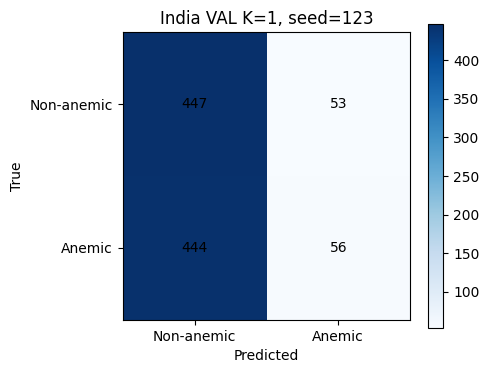


India VAL  2-shot


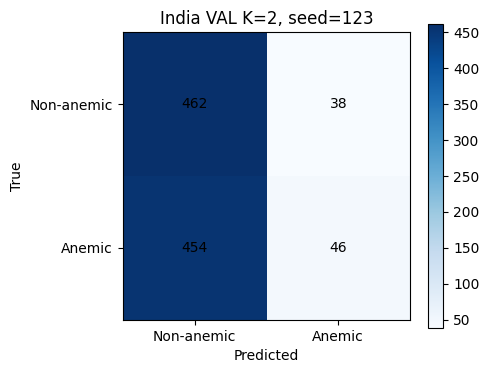


India VAL  5-shot


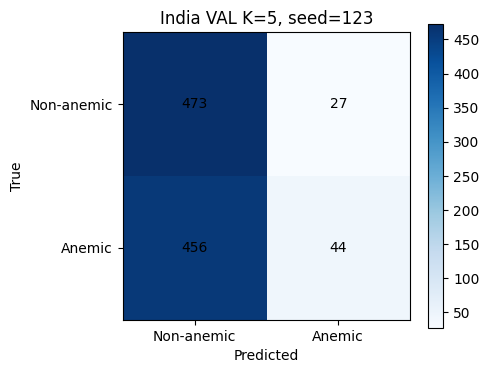

In [ ]:
for K in [1, 2, 5]:
    print(f"\nIndia VAL  {K}-shot")
    summary, df_metrics, cm = eval_and_plot_confusion_matrix(
        model=model,
        df_split=df_val,
        dataset=val_dataset,
        sampler=val_sampler,
        K=K,
        n_query_per_class=5,
        p_same=0.3,     # match training mixture
        inner_lr=1e-2,
        inner_steps=1,
        n_episodes=100,
        device=device,
        seeds=(123, 456, 789),
        seed_for_cm=123,
        title_prefix="India VAL"
    )

### Confusion Matrices for India VAL (K = 1, 2, 5)

For each K-shot setting, I visualized a confusion matrix using the **validation set from India**.  
These plots show how the adapted model performs on individual images after K-shot adaptation,  
using **seed = 123** for reproducibility.

Across all K values (1, 2, 5):
- The model predicts **non-anemic** correctly most of the time.
- It struggles with **anemic** detection, leading to many false negatives.
- Increasing K slightly reduces false positives but sensitivity remains low.



 Italy TEST 1-shot


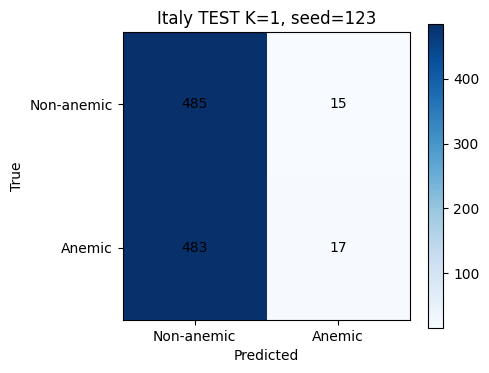


 Italy TEST 2-shot


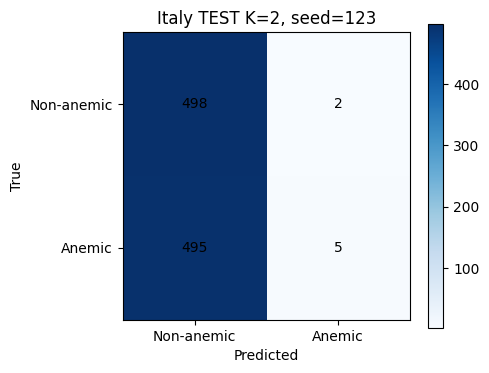


 Italy TEST 5-shot


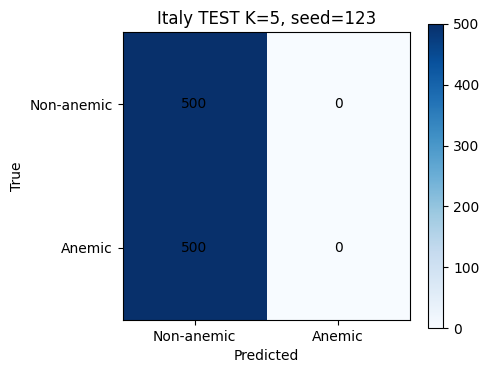

In [ ]:
for K in [1, 2, 5]:
    print(f"\n Italy TEST {K}-shot")
    summary, df_metrics, cm = eval_and_plot_confusion_matrix(
        model=model,
        df_split=df_test,
        dataset=test_dataset,
        sampler=test_sampler,
        K=K,
        n_query_per_class=5,
        p_same=0.0,     # unseen patients → different-patient episodes
        inner_lr=1e-2,
        inner_steps=1,
        n_episodes=100,
        device=device,
        seeds=(123, 456, 789),
        seed_for_cm=123,
        title_prefix="Italy TEST"
    )


### Confusion Matrices for Italy TEST (K = 1, 2, 5)

For the Italy **test set**, I plotted confusion matrices for K = 1, 2, and 5 using only original images and the Italy-specific sampler (different-patient episodes).

- As K increases, the model becomes more conservative and almost always predicts **non-anemic**.
- For **K = 1**, a small number of anemic images are correctly detected, but most positives are missed.
- For **K = 2**, true anemic detections drop further and false negatives dominate.
- For **K = 5**, the model predicts **non-anemic for every image**, resulting in perfect specificity but zero sensitivity.

``
